# CMA for CartPole

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cma
import numpy as np
import math
import rpyc
from IPython import display
import time
from sklearn.linear_model import LinearRegression

In [4]:
try:
    ROBOT_HOSTNAME = "ev3dev.local"
    conn = rpyc.classic.connect(ROBOT_HOSTNAME)
    conn.execute("print('Hello Slave. I am your master!')")
except:
    raise Exception('No conection to rpyc server on robot possible! Is the robot conneced? Is the rpyc server started?')
    


In [84]:
class RobotControllerVerboseWrapper(RobotControler):
    """
    Wrapper / decorator for the robot controller to add verbose logging
    for design pattern see https://github.com/faif/python-patterns/blob/master/structural/decorator.py
    """
    def __init__(self, robotControler):
        self.wrapped = robotControler
        self.last_move = time.time()
        
    def reset(self):
        return self.wrapped.reset()
    
    def get_rate_and_angle(self):
        return self.wrapped.get_rate_and_angle()
    
    def get_current_leg_pos(self):
        return self.wrapped.get_current_leg_pos()
    
    def move_legs(self, pos):
        print("Moving legs to {}, time since last move {}".format(pos, time.time() - self.last_move))
        self.last_move = time.time()
        return self.wrapped.move_legs(pos)

class RobotControllerExceptionWrapper(RobotControler):
    """
    Wrapper / decorator for the robot controller to handle time out exceptions
    for design pattern see https://github.com/faif/python-patterns/blob/master/structural/decorator.py
    """
    def __init__(self, robotControler):
        self.wrapped = robotControler
        
    def reset(self):
        try:
            return self.wrapped.reset()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.reset()
    
    def get_rate_and_angle(self):
        try:
            return self.wrapped.get_rate_and_angle()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.get_rate_and_angle()
    
    def get_current_leg_pos(self):
        try:
            return self.wrapped.get_current_leg_pos()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.get_current_leg_pos()
    
    def move_legs(self, pos):
        try:
            return self.wrapped.move_legs(pos)
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.move_legs(pos)
            

class RobotController:
    """
    The robot controller class.
    """
    def __init__(self, connection):
        motor_module = connection.modules['ev3dev2.motor']
        self.motors = [motor_module.LargeMotor('outB'), motor_module.LargeMotor('outC')]
        sensors = conn.modules['ev3dev2.sensor.lego'] 
        self.gyro = sensors.GyroSensor('in2')
        
        self.motors[0].stop_action = 'hold'
        self.motors[1].stop_action = 'coast'
        
        self.up_position_degrees = -90 # position of legs fully in front
        self.maxspeed = 80 # maximum speed of leg movement
        self.minspeed = 3 # minimum speed of leg movement
        self.angle_normalizer = 0.01
        self.rate_normalizer = 0.01
        
        
    
    def reset(self):
        """ resets the robot, performs calibration and maintainance, return when robot is reset.
        Called at the start of each episode"""
        # move legs to base position
        self._move_motors_to_pos(0, 20)
        self._wait_until_no_standstill(tolerance = 0.05)
        _, angle = self.get_rate_and_angle()
        if abs(angle) >= 0.04:
            # drifted pretty far, recalibrate
            self._wait_until_no_standstill(tolerance = 0.01)
            self._calibrate_gyro()
            return
    
    def get_rate_and_angle(self):
        """ returns the rate and angle of the robot movement"""
        angle, rate = self.gyro.rate_and_angle
        return (rate * self.rate_normalizer, angle * self.angle_normalizer)

    def get_current_leg_pos(self):
        """ returns the curent leg pos, on a [-1, 1] interval"""
        return self.motors[0].position /  self.up_position_degrees
    
    def move_legs(self, pos):
        """ instructs the robot where to move its legs to, on a [-1, 1] interval. Function returns immediatly."""
        pos = max(-1., min(pos, 1.))
        pos_now = self.get_current_leg_pos()
        
        s = abs(pos - pos_now) / 2 *  self.maxspeed
        s = max(self.minspeed, min(s,  self.maxspeed))
        
        self._move_motors_to_pos(pos, s)
        return
    
    def _move_motors_to_pos(self, pos, speed):
        """
        moves the motors to a position [-1, 1] at speed [0,100].
        """
        assert -1. <= pos <= 1.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        assert 0. <= speed <= 100.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        
        self.motors[0].on_to_position(speed, position=pos*self.up_position_degrees, brake=True, block=False) # moves motors, non blocking.
        return
            
            
    def _calibrate_gyro(self):
        print('calibrating gyro')
        self.gyro.mode='GYRO-CAL'
        time.sleep(1)
        self.gyro.mode="GYRO-ANG"
        
    def _wait_until_no_standstill(self, tolerance=0.01):
        """
        waits until the gyro acceleration does not change for 3 seconds
        """
        print("Waiting to stand still.")
        change = 9999
        while abs(change) > tolerance: 

            rates = []
            times = []
            # sample for one second
            t0 = t = time.time()
            while t - t0 < 3:
                _, rate = self.gyro.rate_and_angle
                rates.append(rate)
                t = time.time()
                times.append(t)


            # check change in accel with linreg
            rates = abs(np.array(rates)) # take absolute rates so swinging doesnt cancel each other out
            times = np.array(times)
            lr = LinearRegression()
            lr.fit(times[:, np.newaxis], rates)  
            change = lr.coef_

        return
        

In [6]:
# Helper functions for setting the parameters of the neural network
def number_of_trainable_parameters(session):
    variables_names = [v.name for v in tf.trainable_variables()]
    values = session.run(variables_names)    
    number_of_parameters = 0
    for v in values:
        number_of_parameters += v.size
    return number_of_parameters

def set_trainable_parameters(session, parameter_vector):
    assert number_of_trainable_parameters(session) == parameter_vector.size, \
      'number of parameters do not match: %r vs. %r' % (number_of_trainable_parameters(session), parameter_vector.size)
    variables_names = [v.name for v in tf.trainable_variables()]
    values = session.run(variables_names) 
    idx = 0
    for k, v in zip(tf.trainable_variables(), values):    
        new_value = parameter_vector[idx:idx + v.size].reshape(v.shape)
        k.load(new_value, session)  # load does not add a new node to the graph
        idx += v.size

In [13]:
# Simple evaluation function, just considering a single (random) start state
def swing_motion(x, sess):
    # set params to NN
    set_trainable_parameters(sess, x)
    
    # reset swing
    rc.reset()
    
    # simulate
    reward = 0
    starttime = time.time()
    rate, angle = rc.get_rate_and_angle()
    while time.time()-starttime <30 :
        state = np.array((rate, angle, rc.get_current_leg_pos()))
        
        out = sess.run(action, {inputs: state.reshape(1,*state.shape)})[0][0]
        rc.move_legs(out)
        
        rate, angle = rc.get_rate_and_angle()
        reward = max(reward, abs(rate))
    
    # log rewards of session
    print("total reward for session: ",reward)
    weights.append(x)
    timestep.append(starttime)
    rewards.append(reward)
    return -reward

In [24]:

state_space_dimension = 3
number_of_actions = 1
number_of_hidden_neurons = 2



In [93]:
weights = []
timestep = []
rewards = []

rc = RobotControllerExceptionWrapper(RobotController(conn))

In [ ]:
tf.reset_default_graph()

# Define policy network mapping state to action
with tf.name_scope('policy_network'):
    inputs = tf.placeholder(shape=[1, state_space_dimension],dtype=tf.float32) 
    #hidden = tf.layers.dense(inputs, number_of_hidden_neurons, activation=tf.tanh, use_bias=True)
    action = tf.layers.dense(inputs, number_of_actions, activation=tf.tanh, use_bias=True)

# Do the learning
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    sess.graph.finalize()  # graph is read-only after this statement
    #initial_weights = np.random.normal(0, 0.1, number_of_trainable_parameters(sess))
    # best guess for starting weights: 
    #     small bias of 0.2 to start the movement
    #     large weight to move in the direction of the rate
    #     smaller negative weight to move less extreme when on a far end
    #     no factor for current  leg position, dont know what to take here
    initial_weights = np.array([0.2, 10, -5, 0]) 
    res = cma.fmin(swing_motion, initial_weights, 1, {'timeout': 15 * 60**2, 'ftarget':-4.,}, args=([sess]), restart_from_best=True)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=588418, Mon Jan 14 19:43:17 2019)
Waiting to stand still.


In [90]:
weights

[array([  0.34711997,  11.07266434,  -5.79505983,   1.0993171 ]),
 array([  0.47276383,  11.56791681,  -5.15646722,  -1.63425015]),
 array([  0.52758395,  10.58858038,  -5.31733644,  -0.88362596]),
 array([ 1.2518449 ,  9.50528327, -3.51614206,  0.69607123]),
 array([  1.19426518,  10.05753765,  -5.68917123,  -1.3402381 ]),
 array([  0.220592  ,  10.52435231,  -4.67890486,   0.63580473]),
 array([  0.88236129,  10.77981259,  -5.99898783,  -1.41985678]),
 array([ 0.73945717,  9.65760295, -4.7226117 , -0.31494239]),
 array([ 0.63430316,  9.66949661, -2.40652148,  0.56691705]),
 array([ 1.58496894,  9.89564531, -3.29382014, -1.68824653]),
 array([-0.21719522,  9.66978252, -4.18272987, -0.41659286]),
 array([  1.43722909,  11.43560349,  -3.55909927,  -0.58617087]),
 array([ 1.08067225,  9.28879219, -3.97915654, -0.41638443]),
 array([ 1.17327013,  8.56944006, -3.72340097, -0.78859008]),
 array([  0.58654138,  10.30210889,  -3.30642588,   1.21779159]),
 array([  1.93692369,  10.0679225 ,  -

In [91]:
rewards

[0.58,
 0.54,
 0.52,
 0.59,
 0.58,
 0.55,
 0.59,
 0.68,
 0.48,
 0.39,
 0.56,
 0.43,
 0.52,
 0.64,
 0.6900000000000001,
 0.55,
 0.51,
 0.53,
 0.35000000000000003,
 0.56]

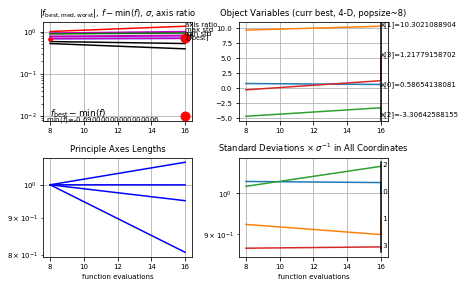

In [92]:
cma.plot()